# Linear Programming Algorithm
Objective: 
* minimize the absolute (or squared) difference between the grade adjusted pace of each segment and the optimal pace
* minimize the magnitude of pace change
* maximize the distance between different pace changes

Constraints: 
* Have at most k different pace segments throughout the entire loop
* Total time of paces should equal the goal time

### Mathematical Formulation:
$$\text{minimize } \sum_{i}^{n-1} |p_i - \text{op}_i| \text{ or minimize }\sum_{i}^{n-1} (p_i - \text{op}_i)^2$$
$$\text{s.t.} \sum_{i}^{n-1} d_i \cdot p_i = gt$$
$$M \cdot z_i \geq p_{i+1} - p_i \quad i = 0...n-2$$
$$M \cdot z_i \geq p_{i} - p_{i+1} \quad i = 0...n-2$$

$$\sum_{i}^{n-2} z_i = k$$
$$z_i \in {0, 1}, p_i \geq 0$$

Where:
* $z_i$ is a binary variable which is 0 when segment i has the same pace as segment i+1 and 0 otherwise.
* $p_i$ is the optimal pace of segment i
* $M$ is a large constant
* $k$ is the maximum number of pace changes  
* $op_i$ = Optimal pace for segment i

For absolute difference linearization:
$$\text{maximize } \sum_{i} t_i$$
$$t_i \geq p_i - \text{op}_i$$
$$t_i \geq \text{op}_i - p_i$$

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import sys
import os
from abc import ABC, abstractmethod

sys.path.append(os.path.abspath("../src"))

import race_course
import utils
from pacing_plan import *

In [22]:
class PacingPlanLP(PacingPlan, ABC):
    def __init__(self, race_course, target_time, total_paces):
        super().__init__(race_course, target_time, total_paces)
        self.paces = None

    @abstractmethod
    def define_variables(self):
        """
        Defines the extra variables needed for the LP problem.
        """
        pass

    @abstractmethod
    def formulate_objective(self):
        """
        Defines the objective function for the LP problem.
        """
        pass

    @abstractmethod
    def formulate_constraints(self):
        """
        Defines the constraints for the LP problem.
        """
        pass

    def formulate_lp_problem(self, M=1):
        self.paces = cp.Variable(self.get_n_segments())
        self.define_variables()
        objective = self.formulate_objective()
        constraints = [
            self.paces @ self.get_distances() == self.target_time,
            self.paces >= 0,
        ]
        constraints += self.formulate_constraints()
        
        return cp.Problem(objective, constraints)

    def solve_lp_problem(self):
        problem = self.formulate_lp_problem()
        problem.solve(solver=cp.GUROBI)
        
        if problem.status == cp.OPTIMAL:
            self.true_paces_full = self.paces.value
        else:
            raise ValueError("LP problem is infeasible")

    def _calculate_recommendations(self, verbose):
        self.solve_lp_problem()
        return self.true_paces_full

In [23]:
class PacingPlanLPAbsolute(PacingPlanLP):
    def __init__(self, race_course, target_time, total_paces):
        super().__init__(race_course, target_time, total_paces)
        self.M = 1
    
    def define_variables(self):
        n_segments = self.get_n_segments()
        self.changes = cp.Variable(n_segments-1, integer=True)
        self.absolutes = cp.Variable(n_segments)

    def formulate_objective(self):
        return cp.Minimize(cp.sum(self.absolutes))

    def formulate_constraints(self):
        n_segments = self.get_n_segments()
        constraints = [
            self.changes >= 0,
            self.changes <= 1,
            cp.sum(self.changes) == self.current_m_paces - 1,
            self.absolutes >= self.paces - (self.optimal_paces),
            self.absolutes >= (self.optimal_paces) - self.paces
        ]
        constraints += [self.M*self.changes[i] >= self.paces[i+1] - self.paces[i] for i in range(n_segments-1)]
        constraints += [self.M*self.changes[i] >= self.paces[i] - self.paces[i+1] for i in range(n_segments-1)]
        return constraints

In [27]:
class PacingPlanLPSquare(PacingPlanLP):
    def __init__(self, race_course, target_time, total_paces):
        super().__init__(race_course, target_time, total_paces)
        self.M = 1
    
    def define_variables(self):
        n_segments = self.get_n_segments()
        self.changes = cp.Variable(n_segments-1, integer=True)

    def formulate_objective(self):
        return cp.Minimize(cp.sum_squares(self.paces - self.optimal_paces))

    def formulate_constraints(self):
        n_segments = self.get_n_segments()
        constraints = [
            self.changes >= 0,
            self.changes <= 1,
            cp.sum(self.changes) == self.current_m_paces - 1,
        ]
        constraints += [self.M*self.changes[i] >= self.paces[i+1] - self.paces[i] for i in range(n_segments-1)]
        constraints += [self.M*self.changes[i] >= self.paces[i] - self.paces[i+1] for i in range(n_segments-1)]
        return constraints

In [28]:
class PacingPlanAvgPacePerMile(PacingPlan):
    def __init__(self, race_course, target_time, total_paces):
        super().__init__(race_course, target_time, total_paces)

    def _calculate_recommendations(self, verbose):
        self.gen_pace_per_mile(self.optimal_paces)
        for i in range(self.get_n_segments()):
            mile = int(self.race_course.start_distances[i])
            self.true_paces_full[i] = self.pace_per_mile[mile]
        return self.true_paces_full

In [29]:
class PacingPlanAvgPace(PacingPlan):
    def __init__(self, race_course, target_time, total_paces):
        super().__init__(race_course, target_time, total_paces)

    def _calculate_recommendations(self, verbose):
        avg_pace = self.target_time / self.race_course.total_distance
        self.true_paces_full[:] = avg_pace
        return self.true_paces_full

In [19]:
file_path = "../data/Lakefront-Loops-5K.gpx"
course_name = os.path.basename(file_path).split('.')[0]
course = race_course.RealRaceCourse(course_name, file_path)

In [30]:
lp_plan = PacingPlanLPSquare(course, 20, 6)
bf_plan = PacingPlanBruteForce(course, 20, 6)
ppm_plan = PacingPlanAvgPacePerMile(course, 20, 6)

In [31]:
lp_plan.calculate_recommendations()
bf_plan.calculate_recommendations()
ppm_plan.calculate_recommendations()
pass

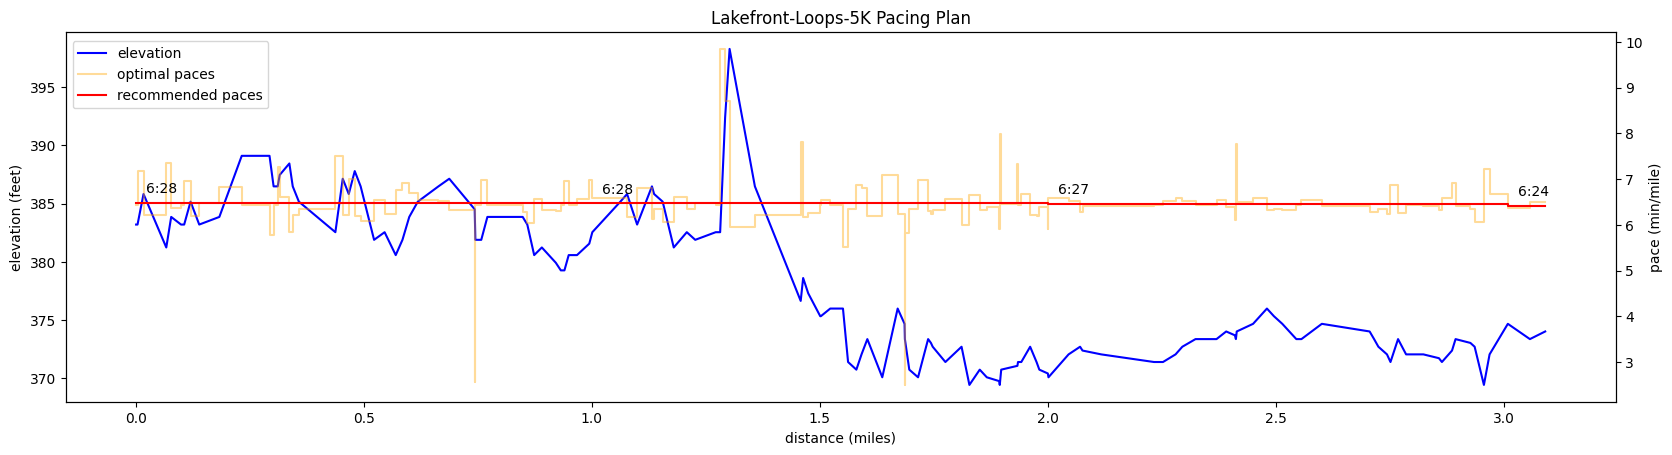

In [10]:
ppm_plan.gen_pace_chart('../results/ppm_plan.png', incl_opt_paces=True)

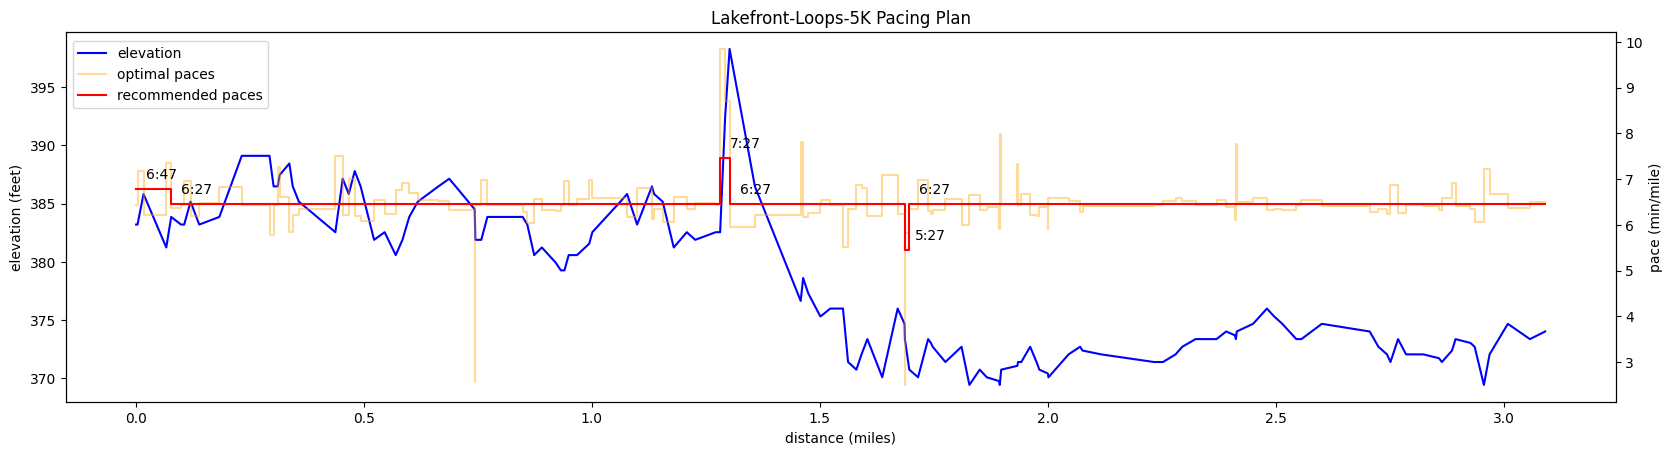

In [32]:
lp_plan.gen_pace_chart('../results/lp_plan.png', incl_opt_paces=True)

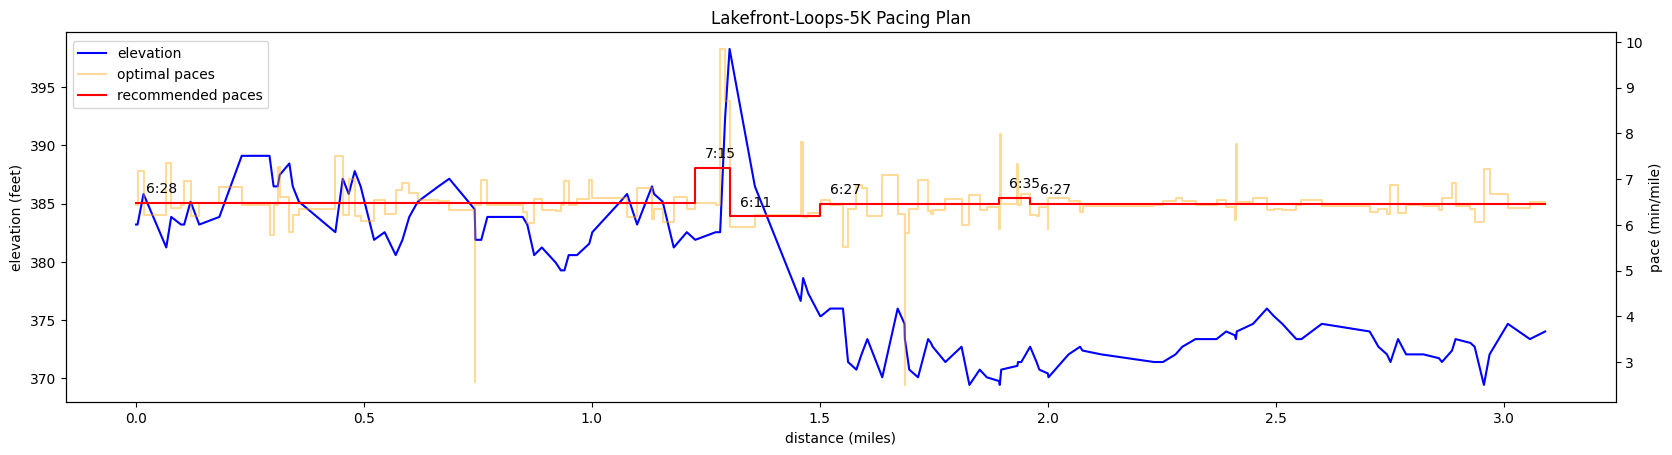

In [12]:
bf_plan.gen_pace_chart('../results/bf_plan.png', incl_opt_paces=True)

In [8]:
print(lp_plan.gen_full_text())

0, 6.4951229708762215, 42.45424297723653, -76.51540146015358, 383.202112, 0.003111846221000508, 0.020211823871854762 
1, 6.4951229708762215, 42.45428539934814, -76.51542196197128, 383.202112, 0.013166228596696486, 0.08551627379821074 
2, 6.4951229708762215, 42.45446458754386, -76.51550983680535, 385.826784, 0.04990816394308232, 0.32415966206097035 
3, 6.4951229708762215, 42.45512460402434, -76.51590762698363, 381.233608, 0.010793552538302525, 0.07010545102888809 
4, 6.4951229708762215, 42.45524502358542, -76.51604250429915, 383.85828, 0.021601495785825327, 0.14030437148379998 
5, 6.4951229708762215, 42.455541, -76.515906, 383.202112, 0.006875803910643037, 0.044659191923258144 
6, 6.4951229708762215, 42.455634, -76.515954, 383.202112, 0.014001224670913382, 0.09093967598044837 
7, 6.4951229708762215, 42.455796, -76.516119, 385.170616, 0.019043344431224966, 0.12368886385755705 
8, 6.4951229708762215, 42.455943, -76.516435, 383.202112, 0.04414125483055003, 0.28670287821320645 
9, 6.4951229

In [9]:
print(bf_plan.gen_full_text())

0, 6.478310000087327, 42.45424297723653, -76.51540146015358, 383.202112, 0.003111846221000508, 0.020159504492241548 
1, 6.478310000087327, 42.45428539934814, -76.51542196197128, 383.202112, 0.013166228596696486, 0.08529491038141458 
2, 6.478310000087327, 42.45446458754386, -76.51550983680535, 385.826784, 0.04990816394308232, 0.32332055755846795 
3, 6.478310000087327, 42.45512460402434, -76.51590762698363, 381.233608, 0.010793552538302525, 0.0699239793453532 
4, 6.478310000087327, 42.45524502358542, -76.51604250429915, 383.85828, 0.021601495785825327, 0.13994118616615647 
5, 6.478310000087327, 42.455541, -76.515906, 383.202112, 0.006875803910643037, 0.04454358923295834 
6, 6.478310000087327, 42.455634, -76.515954, 383.202112, 0.014001224670913382, 0.09070427379904755 
7, 6.478310000087327, 42.455796, -76.516119, 385.170616, 0.019043344431224966, 0.12336868866391201 
8, 6.478310000087327, 42.455943, -76.516435, 383.202112, 0.04414125483055003, 0.2859607325851553 
9, 6.478310000087327, 42

In [10]:
lp_plan.gen_geojson('lp_path.json', False)

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'LineString',
    'coordinates': [[42.45424297723653, -76.51540146015358, 116.8],
     [42.45428539934814, -76.51542196197128, 116.8],
     [42.45446458754386, -76.51550983680535, 117.6],
     [42.45512460402434, -76.51590762698363, 116.2],
     [42.45524502358542, -76.51604250429915, 117.0],
     [42.455541, -76.515906, 116.8],
     [42.455634, -76.515954, 116.8],
     [42.455796, -76.516119, 117.4],
     [42.455943, -76.516435, 116.8],
     [42.456434, -76.516989, 117.0],
     [42.456894, -76.517723, 118.6],
     [42.457061, -76.517864, 118.6],
     [42.457735, -76.517696, 118.6],
     [42.457855205122286, -76.51762938773155, 117.8],
     [42.457939593399495, -76.51749597668648, 117.8],
     [42.45794611722855, -76.51740877919796, 118.1],
     [42.457977, -76.516996, 118.4],
     [42.458049, -76.516888, 117.8],
     [42.458228, -76.516785, 117.4],
     [42.459359, -76.516441, 116.6],
     [42.4595

In [11]:
bf_plan.gen_geojson('lp_path.json', False)

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'LineString',
    'coordinates': [[42.45424297723653, -76.51540146015358, 116.8],
     [42.45428539934814, -76.51542196197128, 116.8],
     [42.45446458754386, -76.51550983680535, 117.6],
     [42.45512460402434, -76.51590762698363, 116.2],
     [42.45524502358542, -76.51604250429915, 117.0],
     [42.455541, -76.515906, 116.8],
     [42.455634, -76.515954, 116.8],
     [42.455796, -76.516119, 117.4],
     [42.455943, -76.516435, 116.8],
     [42.456434, -76.516989, 117.0],
     [42.456894, -76.517723, 118.6],
     [42.457061, -76.517864, 118.6],
     [42.457735, -76.517696, 118.6],
     [42.457855205122286, -76.51762938773155, 117.8],
     [42.457939593399495, -76.51749597668648, 117.8],
     [42.45794611722855, -76.51740877919796, 118.1],
     [42.457977, -76.516996, 118.4],
     [42.458049, -76.516888, 117.8],
     [42.458228, -76.516785, 117.4],
     [42.459359, -76.516441, 116.6],
     [42.4595

In [12]:
print(lp_plan.gen_abbrev_plan())

Lakefront-Loops-5K: 20 minute plan

0: 0.00 mi	6:29/mile for 1.28 mi
1: 1.28 mi	7:25/mile for 0.02 mi
2: 1.30 mi	6:25/mile for 0.28 mi
3: 1.58 mi	6:51/mile for 0.09 mi
4: 1.67 mi	5:51/mile for 0.03 mi
5: 1.70 mi	6:25/mile for 1.40 mi

Total time: 20.00


In [13]:
print(bf_plan.gen_abbrev_plan())

Lakefront-Loops-5K: 20 minute plan

0: 0.00 mi	6:28/mile for 1.23 mi
1: 1.23 mi	7:15/mile for 0.08 mi
2: 1.30 mi	6:11/mile for 0.20 mi
3: 1.50 mi	6:27/mile for 0.39 mi
4: 1.89 mi	6:35/mile for 0.07 mi
5: 1.96 mi	6:27/mile for 1.13 mi

Total time: 20.00


FileNotFoundError: [Errno 2] No such file or directory: '../results/boston/lp_plan.png'

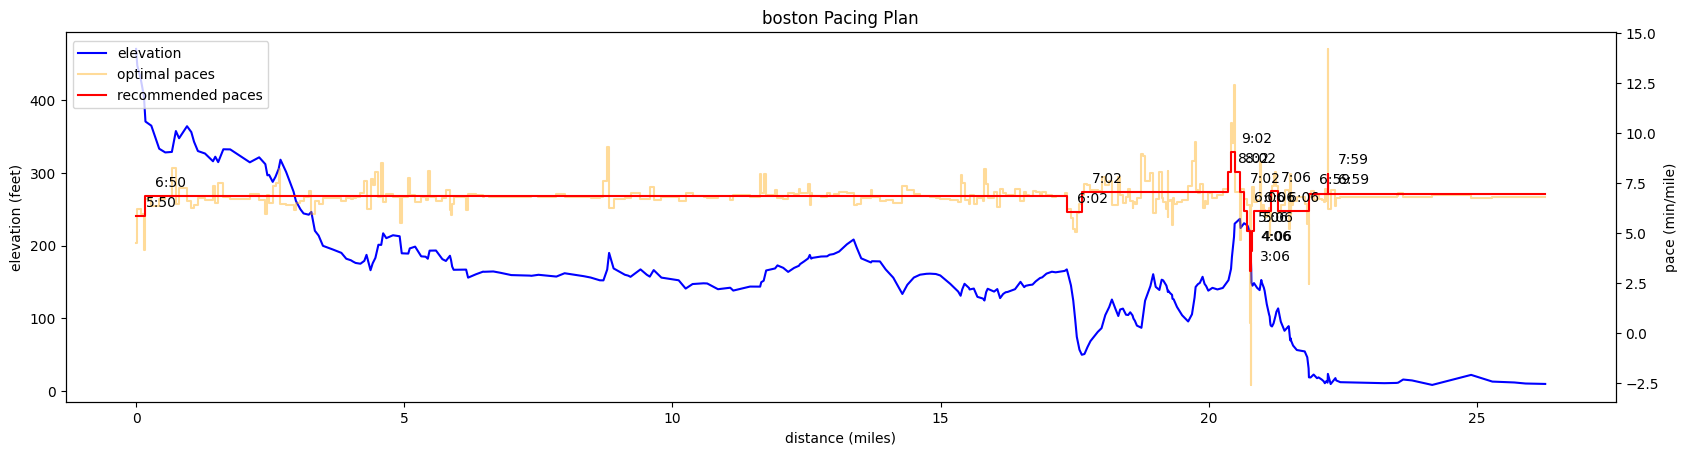

In [15]:
file_path = "../data/boston.gpx"
course_name = os.path.basename(file_path).split('.')[0]
course = race_course.RealRaceCourse(course_name, file_path)
lp_plan = PacingPlanLP(course, 180, 20)
lp_plan.calculate_recommendations()
lp_plan.gen_pace_chart(f'../results/{course_name}/lp_plan.png', True)